In [ ]:
print(-2 % 3)

In [1]:
import numpy as np
import shapely
import bisect
import shapely.wkt
import matplotlib.pyplot as plt
import math
import geopandas as gpd
import json
from bench_utils import parse_intersection_data 

In [2]:
# Geometries
manual_data, _ = parse_intersection_data("manual")
world_data, world_data_stats = parse_intersection_data("world.json", 5)
lund_data, lund_data_stats = parse_intersection_data("lund.json", 5)

In [3]:
SHOW_COORDINATES = True
SHOW_GEOMETRIES = True
SHOW_INTERSECTING_POINTS = False
SHOW_COMMON_BOUNDING_BOX = True
SHOW_BOUNDING_BOXES = True

In [4]:
import intersection.first_bin_search
import intersection.chunk_bbox_intersection
binary_intersection = intersection.first_bin_search.binary_intersection
chunk_bbox_is_intersecting = intersection.chunk_bbox_intersection.is_intersecting
chunk_bbox_intersection = intersection.chunk_bbox_intersection.intersection

from intersection.plotting import *

from algos.alg_fpd_extended import FpdExtended
fpd = FpdExtended()

Expected shape: POLYGON EMPTY
Returned shape: POLYGON EMPTY
[(0, 0, (0, 3), False)]
[(0, 0, (1, 2), True)]


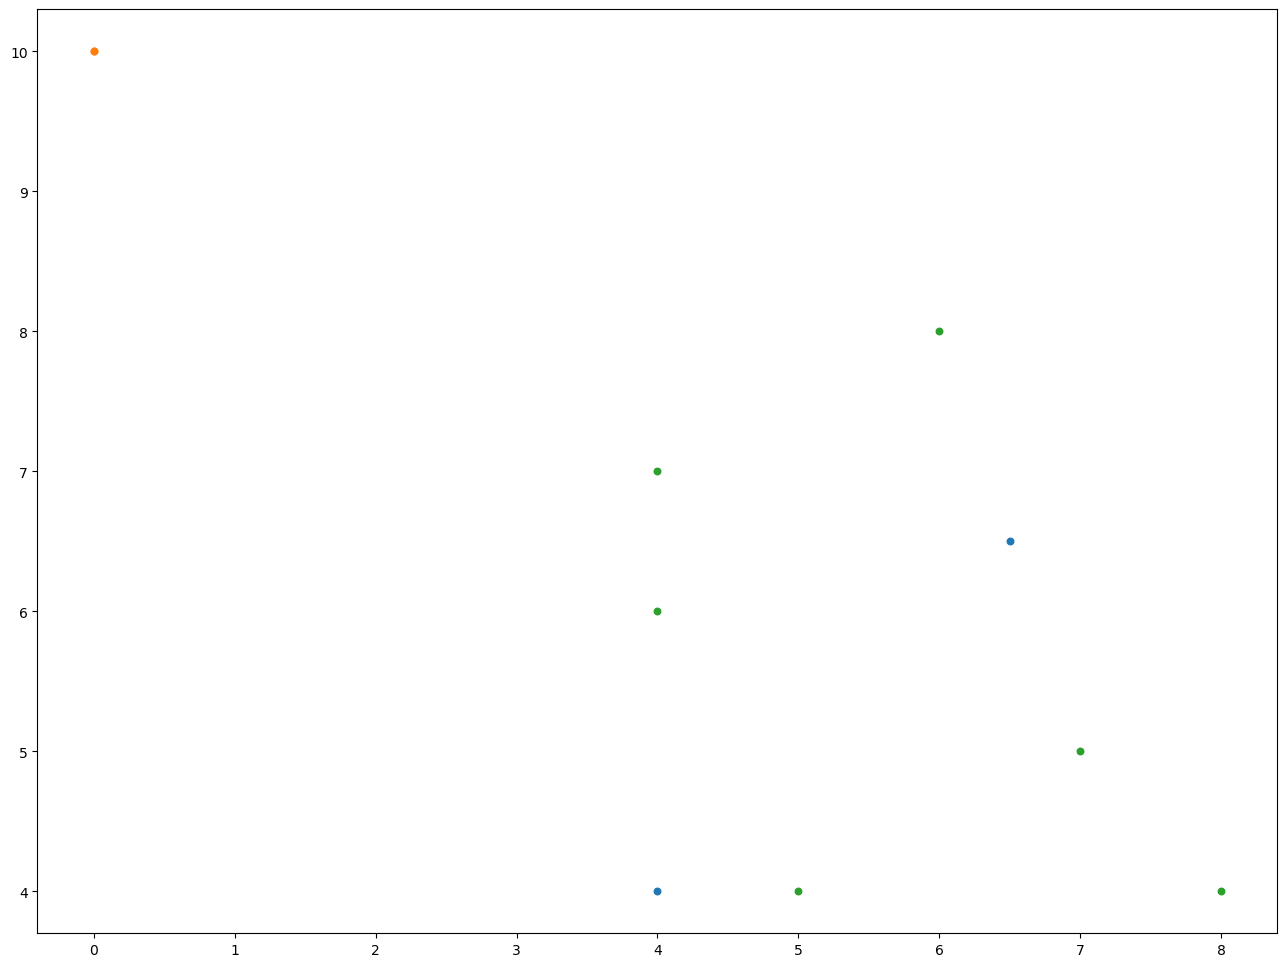

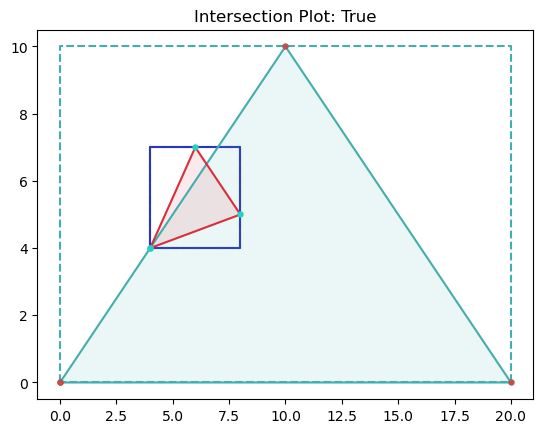

Above FAILED!
Expected shape: POLYGON ((6.5 6.5, 8 5, 4 4, 6.5 6.5))
Returned shape: [[array([6.5, 6.5]), array([4., 4.])], [[[(0.0, 0.0), (10.0, 10.0)]], [[(4.0, 4.0), (6.0, 7.0)], [(6.0, 7.0), (8.0, 5.0)], [(8.0, 5.0), (4.0, 4.0)]]], [defaultdict(<class 'list'>, {0: [0, 1]}), defaultdict(<class 'list'>, {0: [1], 1: [0], 2: [1]})], [[[0], [1]], [[0], [0, 2]]]]


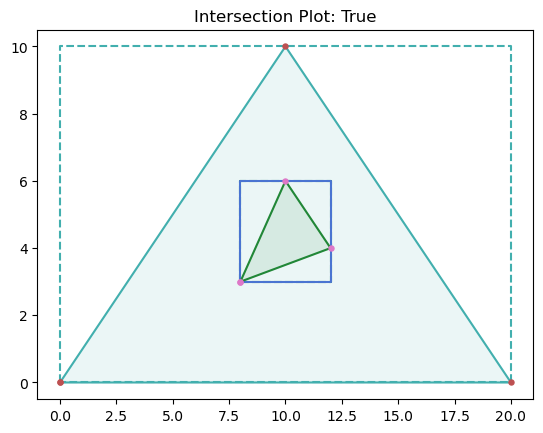

Above FAILED!
Expected shape: POLYGON ((10 6, 12 4, 8 3, 10 6))
Returned shape: POLYGON ((8 3, 10 6, 12 4, 8 3))
Expected shape: POLYGON EMPTY
Returned shape: POLYGON EMPTY
[]
[]


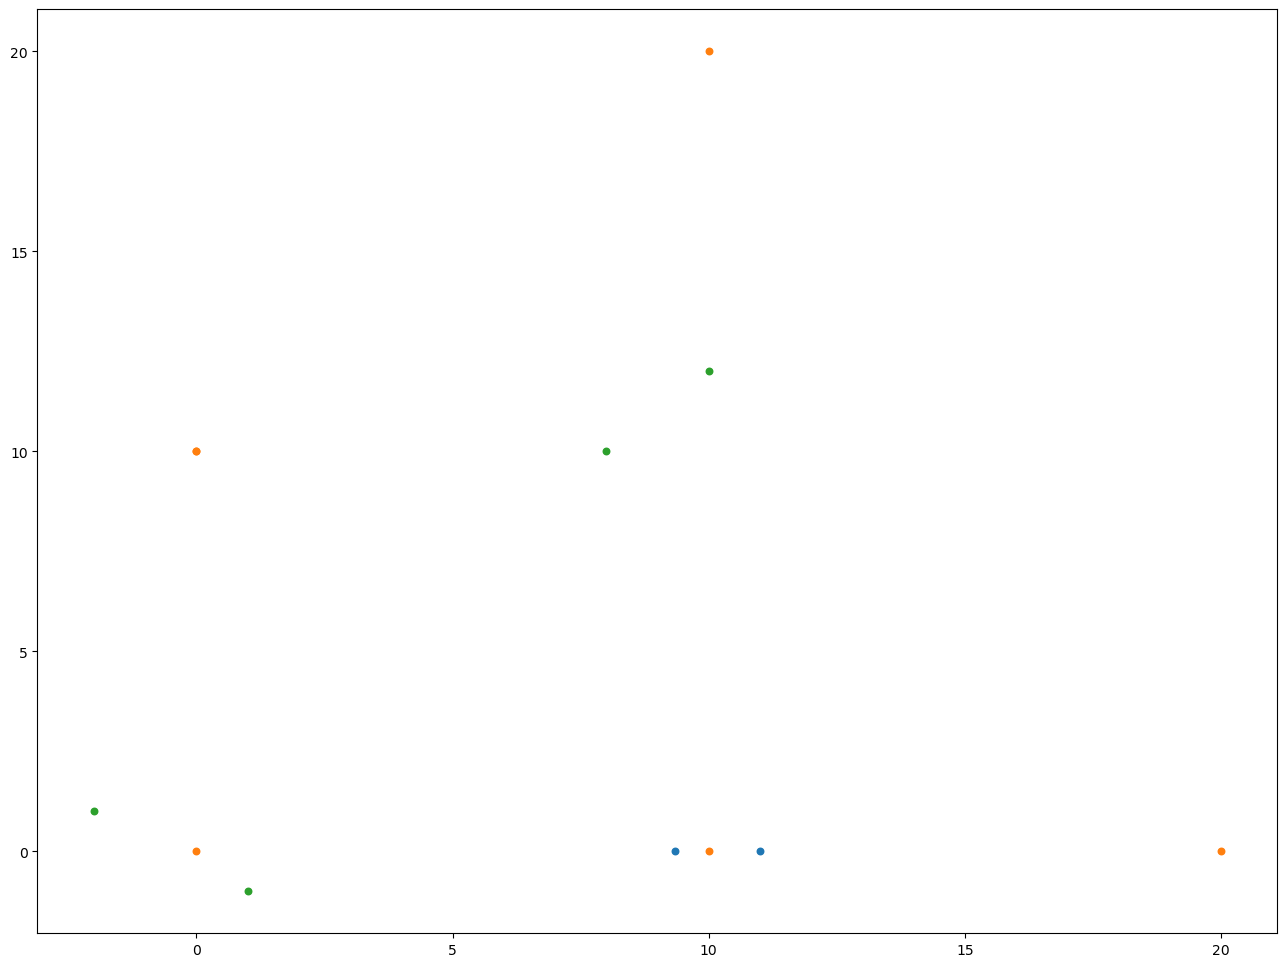

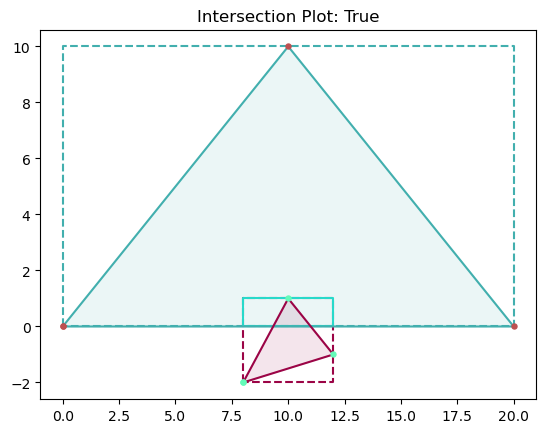

Above FAILED!
Expected shape: POLYGON ((9.333333333333334 0, 10 1, 11 0, 9.333333333333334 0))
Returned shape: [[array([9.33333333, 0.        ]), array([11.,  0.])], [[[(0.0, 0.0), (10.0, 10.0)], [(10.0, 10.0), (20.0, 0.0)], [(20.0, 0.0), (0.0, 0.0)]], [[(8.0, -2.0), (10.0, 1.0)], [(10.0, 1.0), (12.0, -1.0)]]], [defaultdict(<class 'list'>, {0: [], 1: [], 2: [0, 1]}), defaultdict(<class 'list'>, {0: [0], 1: [1]})], [[[2], [0]], [[2], [1]]]]
[(1, 0, (0, 0), True), (1, 0, (0, 3), False)]
[]


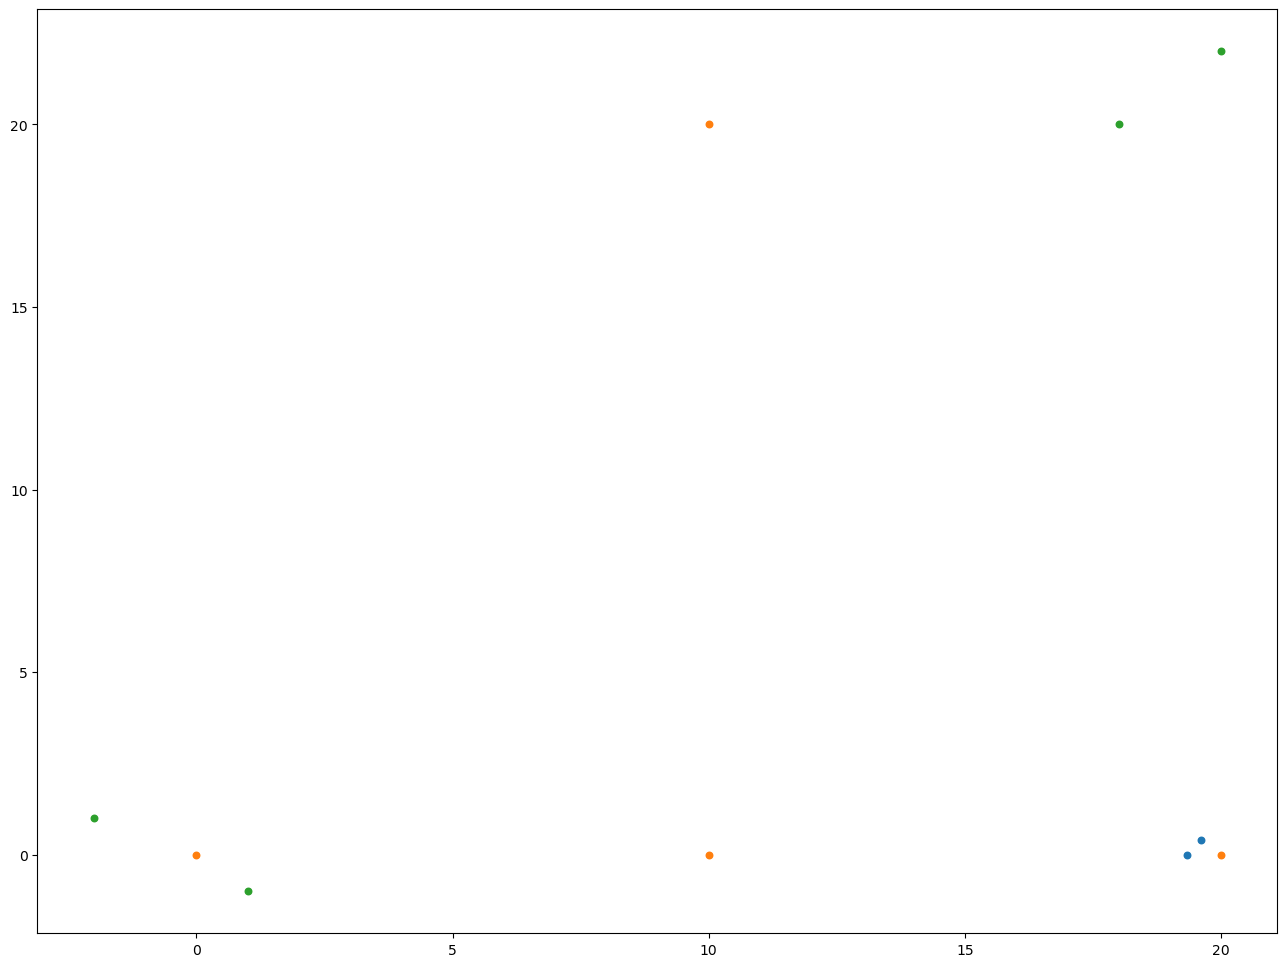

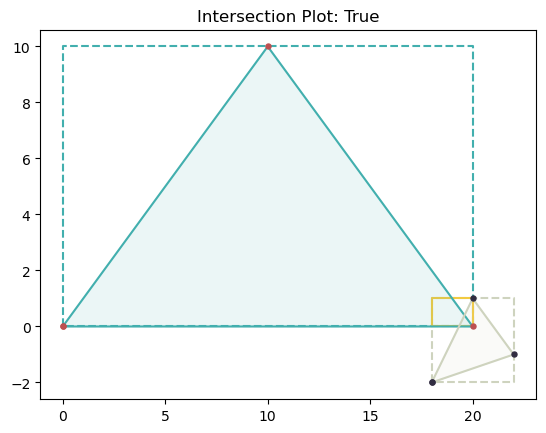

Above FAILED!
Expected shape: POLYGON ((20 0, 19.333333333333332 0, 19.6 0.4, 20 0))
Returned shape: [[array([19.6,  0.4]), array([19.33333333,  0.        ])], [[[(10.0, 10.0), (20.0, 0.0)], [(20.0, 0.0), (0.0, 0.0)]], [[(18.0, -2.0), (20.0, 1.0)], [(20.0, 1.0), (22.0, -1.0)]]], [defaultdict(<class 'list'>, {0: [0], 1: [1]}), defaultdict(<class 'list'>, {0: [0, 1], 1: []})], [[[0], [0]], [[1], [0]]]]
[]
[]


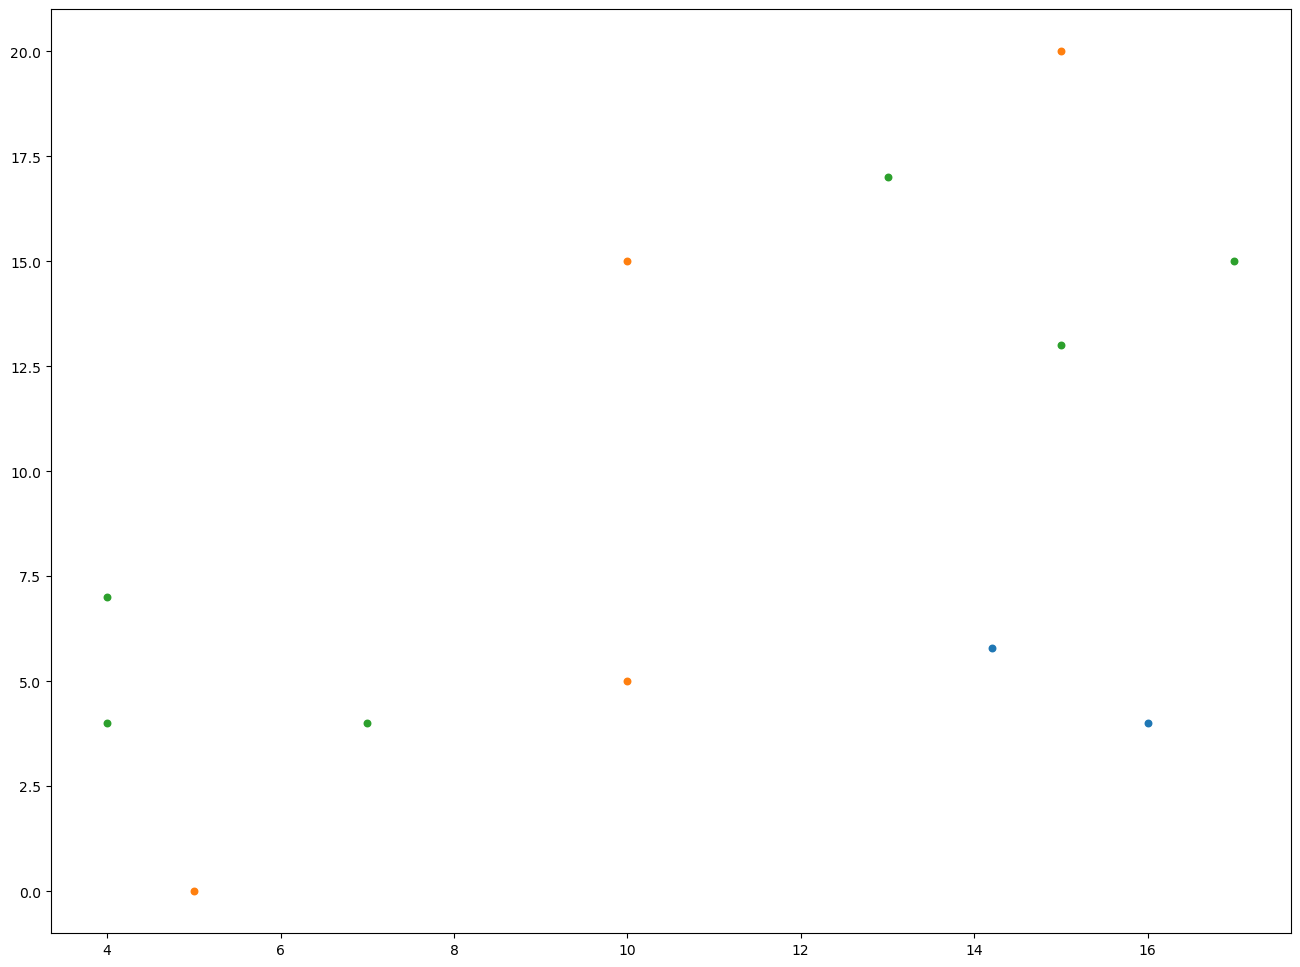

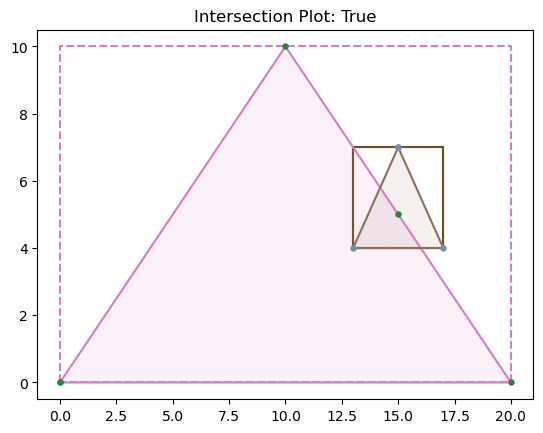

Above FAILED!
Expected shape: POLYGON ((15 5, 16 4, 13 4, 14.2 5.8, 15 5))
Returned shape: [[array([14.2,  5.8]), array([16.,  4.])], [[[(10.0, 10.0), (15.0, 5.0)], [(15.0, 5.0), (20.0, 0.0)]], [[(15.0, 7.0), (13.0, 4.0)], [(13.0, 4.0), (17.0, 4.0)], [(17.0, 4.0), (15.0, 7.0)]]], [defaultdict(<class 'list'>, {0: [0], 1: [1]}), defaultdict(<class 'list'>, {0: [0], 1: [1], 2: []})], [[[0], [0]], [[1], [1]]]]
[(0, 0, (0, 3), False), (0, 57, (0, 0), True), (0, 57, (0, 3), False), (1, 0, (0, 0), True), (1, 0, (0, 3), False), (1, 1, (0, 3), False)]
[(0, 0, (1, 2), True), (0, 0, (1, 4), False), (0, 1, (0, 0), True), (0, 1, (0, 3), False), (1, 0, (1, 4), False)]
[(0, 0, (2, 3), True), (1, 0, (2, 3), True), (1, 95, (1, 2), True), (1, 95, (1, 1), False)]
[(0, 30, (0, 0), True), (0, 30, (0, 3), False), (1, 28, (0, 0), True), (1, 28, (0, 3), False)]
[(0, 30, (1, 2), True), (0, 30, (1, 4), False), (0, 31, (0, 0), True), (0, 31, (0, 3), False), (1, 27, (0, 3), False), (1, 28, (1, 2), True), (1, 28, 

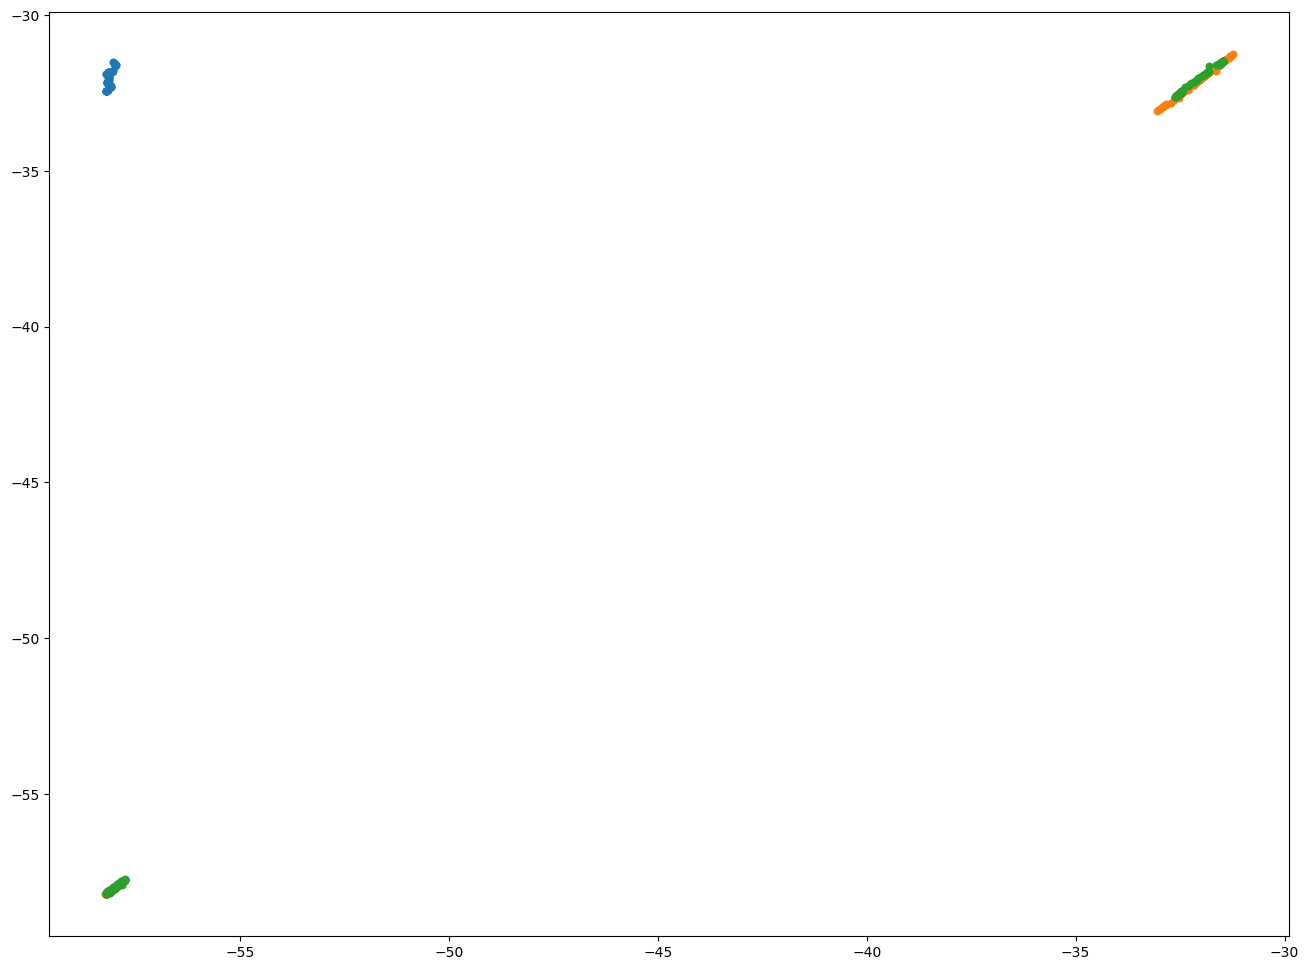

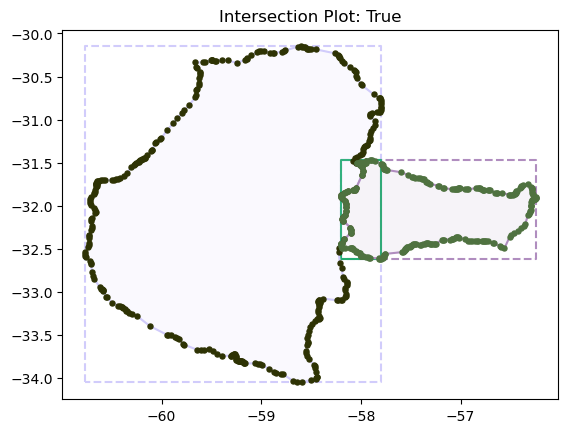

Above FAILED!
Expected shape: MULTILINESTRING ((-58.200111852217844 -32.44712991235971, -58.20012361999997 -32.44720104199993), (-58.03897801142608 -31.50863746924381, -58.01332759699994 -31.525619811999945), (-58.01332759699994 -31.525619811999945, -57.986817585999944 -31.55414520299989), (-57.986817585999944 -31.55414520299989, -57.979582885999974 -31.598793639999926), (-57.979582885999974 -31.598793639999926, -57.98862626099992 -31.642821960999896), (-57.98862626099992 -31.642821960999896, -58.0488809819999 -31.79712778699991), (-58.0488809819999 -31.79712778699991, -58.05926794399991 -31.811493834999922), (-58.05926794399991 -31.811493834999922, -58.08345251499989 -31.819762063999875), (-58.08345251499989 -31.819762063999875, -58.13083980299987 -31.827823587999944), (-58.13083980299987 -31.827823587999944, -58.15285396399986 -31.83598846499997), (-58.15285396399986 -31.83598846499997, -58.16861527499992 -31.8460136919999), (-58.16861527499992 -31.8460136919999, -58.196003784999874 

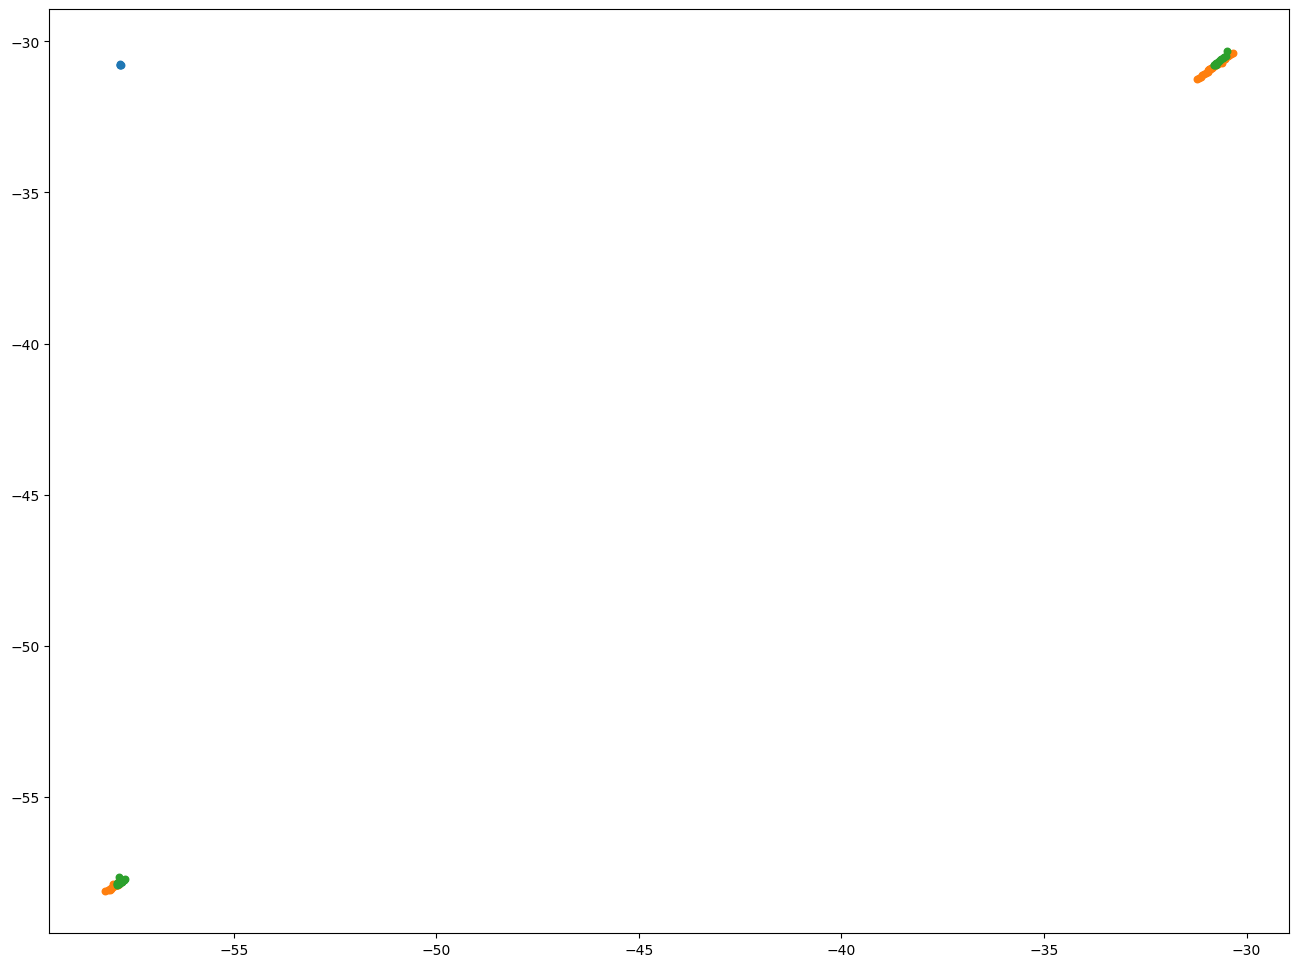

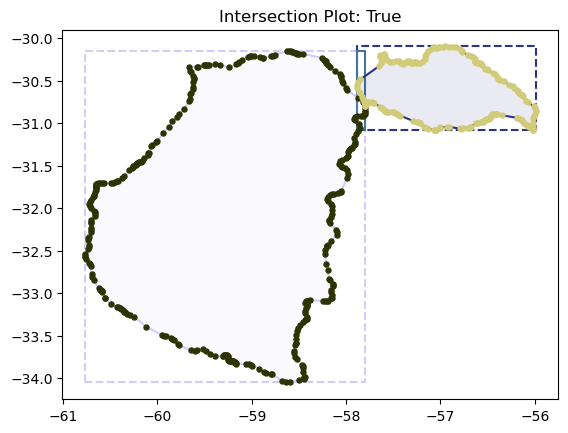

Above FAILED!
Expected shape: MULTILINESTRING ((-57.80865916899995 -30.747331216999925, -57.80186763499998 -30.773314309999932), (-57.80186763499998 -30.773314309999932, -57.79939710209459 -30.791460706446458))
Returned shape: [[array([-57.80865917, -30.74733122]), array([-57.80186763, -30.77331431]), array([-57.80186763, -30.77331431]), array([-57.7993971 , -30.79146071])], [[[(-58.17223181804394, -30.34057667377448), (-58.11365658188572, -30.38977263749723)], [(-58.11365658188572, -30.38977263749723), (-58.06800045405771, -30.420726821185838)], [(-58.06800045405771, -30.420726821185838), (-58.05541724341106, -30.440673922663393)], [(-58.05541724341106, -30.440673922663393), (-58.051515672310416, -30.453282972631087)], [(-58.051515672310416, -30.453282972631087), (-58.044332647733484, -30.499068291668323)], [(-58.044332647733484, -30.499068291668323), (-58.0369945953243, -30.52175424606162)], [(-58.0369945953243, -30.52175424606162), (-57.996790331308716, -30.590328870481017)], [(-57.

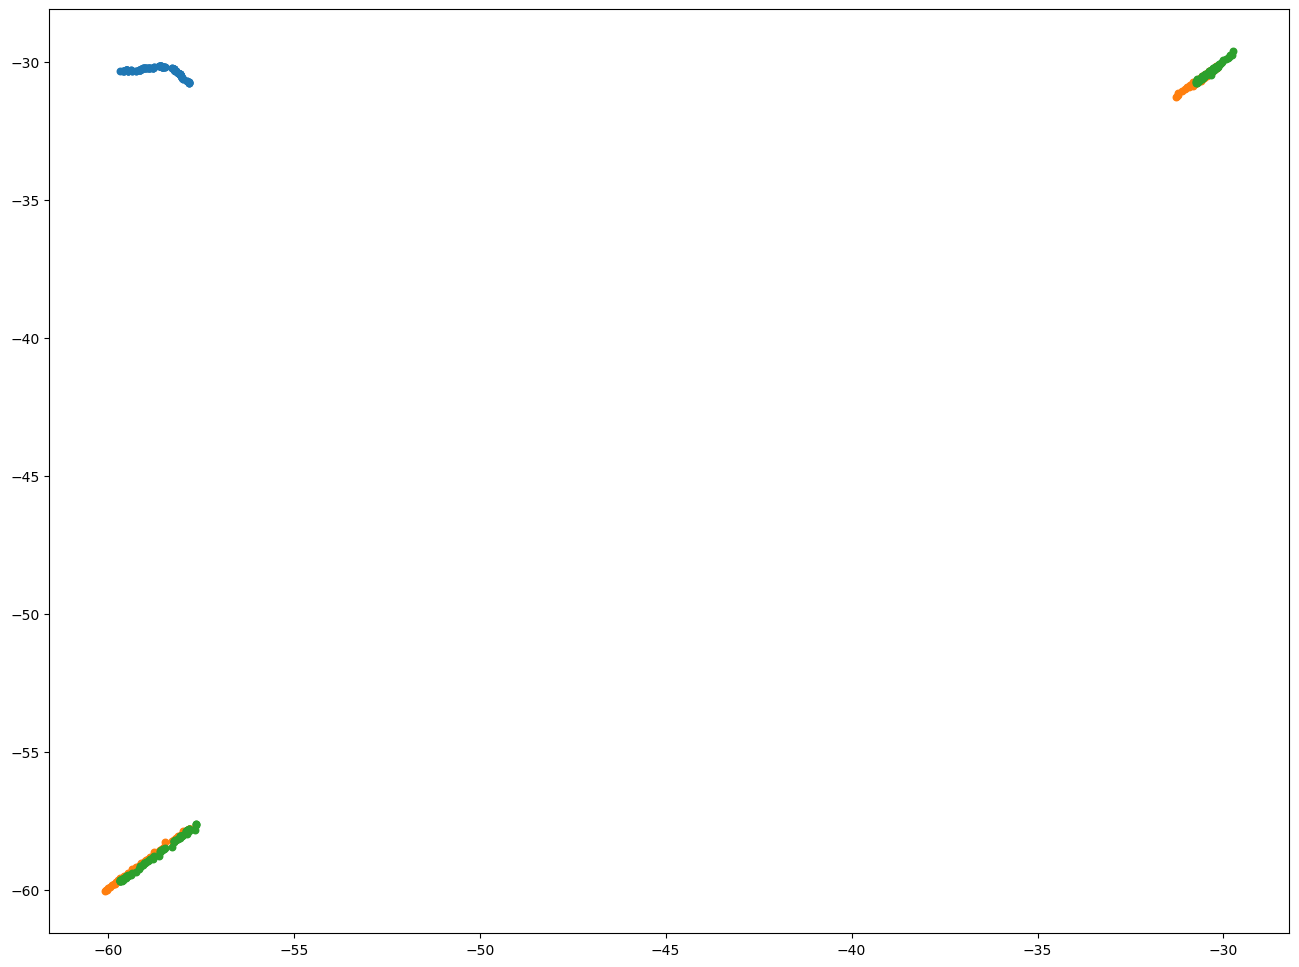

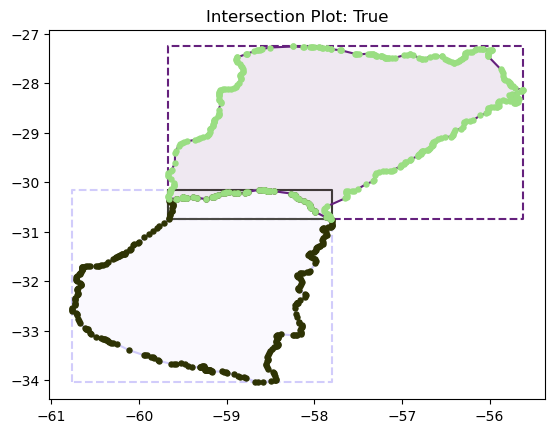

Above FAILED!
Expected shape: MULTILINESTRING ((-59.661520759075756 -30.336907646670568, -59.58002702542689 -30.33427214924029), (-59.58002702542689 -30.33427214924029, -59.56811560744933 -30.332566826897562), (-59.56811560744933 -30.332566826897562, -59.50411434590035 -30.310294284553606), (-59.50411434590035 -30.310294284553606, -59.498662482087866 -30.30905405020428), (-59.498662482087866 -30.30905405020428, -59.494993455883275 -30.30936410856674), (-59.494993455883275 -30.30936410856674, -59.489955003220814 -30.310294284553606), (-59.489955003220814 -30.310294284553606, -59.46391008188476 -30.31918263057395), (-59.46391008188476 -30.31918263057395, -59.455874395686806 -30.3198027481983), (-59.455874395686806 -30.3198027481983, -59.38854000471741 -30.30595346388128), (-59.38854000471741 -30.30595346388128, -59.33691524913945 -30.312723077308192), (-59.33691524913945 -30.312723077308192, -59.24131384965443 -30.34347055362315), (-59.24131384965443 -30.34347055362315, -59.1658662581213

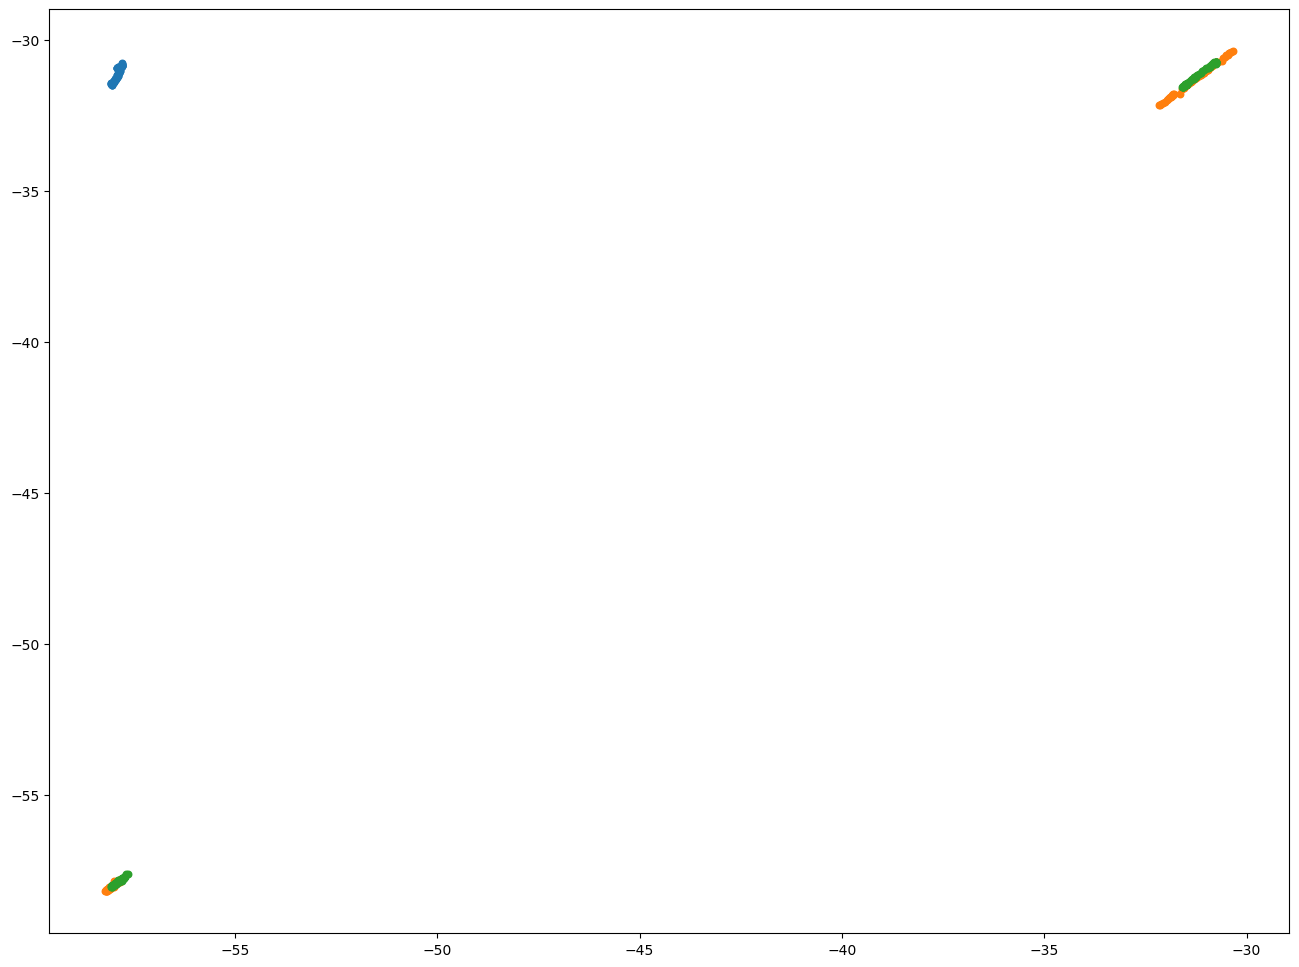

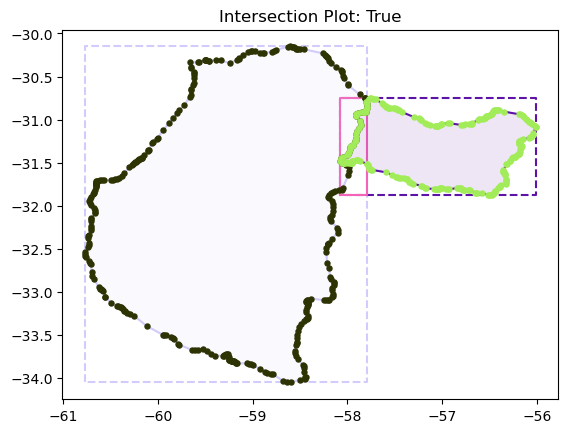

Above FAILED!
Expected shape: MULTILINESTRING ((-57.79939710209459 -30.791460706446458, -57.79602819899989 -30.816205748999977), (-57.79602819899989 -30.816205748999977, -57.79499466999991 -30.857960306999928), (-57.79499466999991 -30.857960306999928, -57.79613155099992 -30.86839894599997), (-57.79613155099992 -30.86839894599997, -57.80186763499998 -30.892480162999917), (-57.80186763499998 -30.892480162999917, -57.80724198499985 -30.907569681999917), (-57.80724198499985 -30.907569681999917, -57.819644327999924 -30.911600442999912), (-57.819644327999924 -30.911600442999912, -57.84279536999992 -30.909223326999964), (-57.84279536999992 -30.909223326999964, -57.88532507299996 -30.91883514399997), (-57.88532507299996 -30.91883514399997, -57.903980265999934 -30.92968719499993), (-57.903980265999934 -30.92968719499993, -57.911731730999946 -30.94736053499993), (-57.911731730999946 -30.94736053499993, -57.905478881999926 -30.95883270199994), (-57.905478881999926 -30.95883270199994, -57.86331091

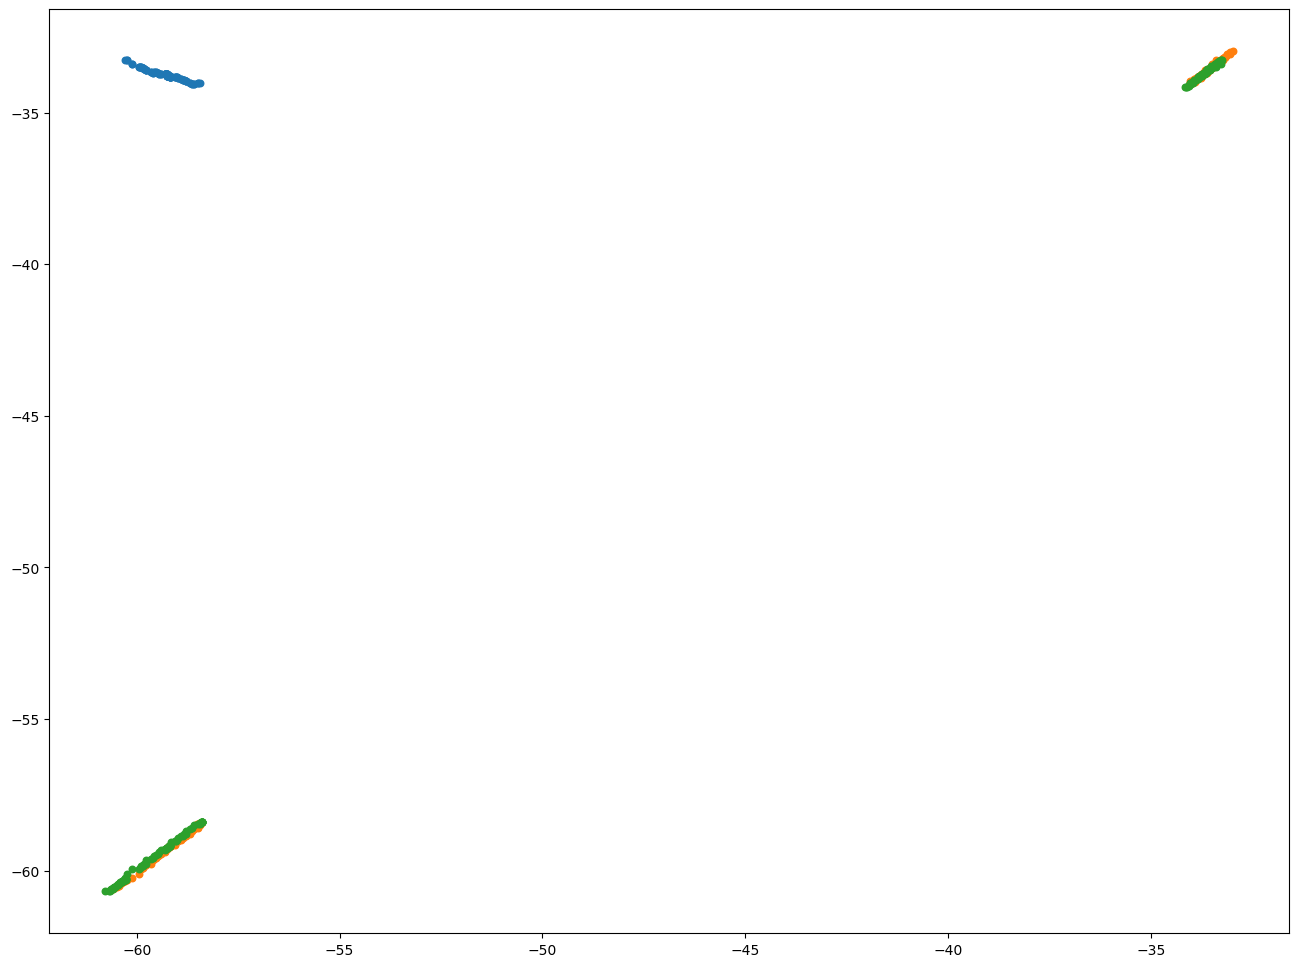

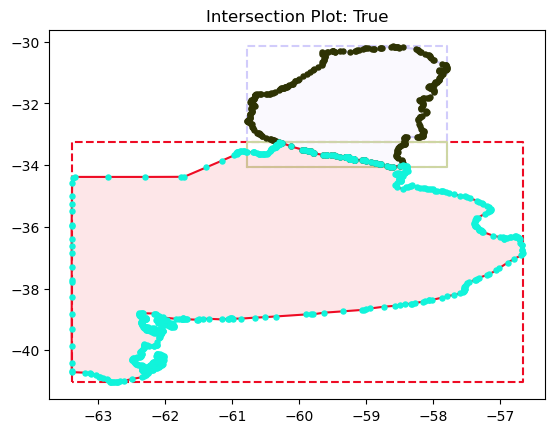

Above FAILED!
Expected shape: MULTILINESTRING ((-58.44697068674776 -34.00694015666289, -58.49960201661975 -34.01668303759209), (-58.49960201661975 -34.01668303759209, -58.590965949119266 -34.04898080751826), (-58.590965949119266 -34.04898080751826, -58.63850826734267 -34.04851571952486), (-58.63850826734267 -34.04851571952486, -58.67979773607664 -34.03120411547752), (-58.67979773607664 -34.03120411547752, -58.78191036567085 -33.95229420241549), (-58.78191036567085 -33.95229420241549, -58.80025550029109 -33.94655811866227), (-58.80025550029109 -33.94655811866227, -58.849348111226334 -33.93730803743597), (-58.849348111226334 -33.93730803743597, -58.867848272779554 -33.92805795710905), (-58.867848272779554 -33.92805795710905, -58.92185014516804 -33.88764698661913), (-58.92185014516804 -33.88764698661913, -58.995230679152485 -33.85075001360224), (-58.995230679152485 -33.85075001360224, -59.01156043216821 -33.83901946367729), (-59.01156043216821 -33.83901946367729, -59.0318175929076 -33.829

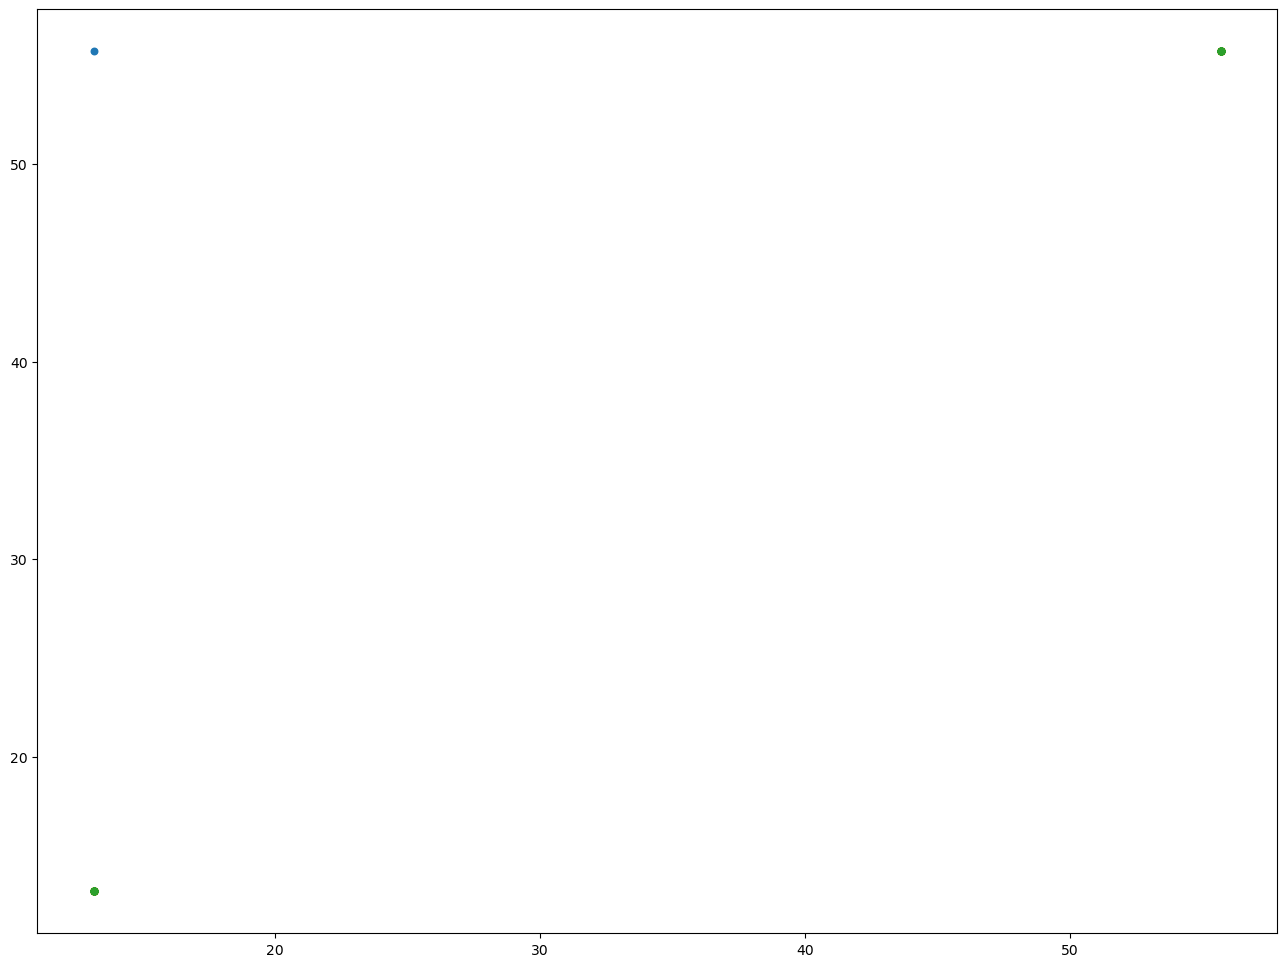

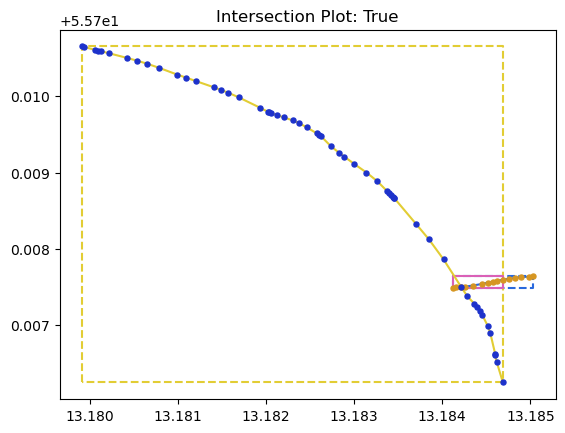

Above FAILED!
Expected shape: POINT (13.184215 55.7074976)
Returned shape: [[array([13.184215 , 55.7074976])], [[[(13.18503, 55.7076404), (13.1849814, 55.7076348)], [(13.1849814, 55.7076348), (13.1848977, 55.7076256)], [(13.1848977, 55.7076256), (13.184826, 55.7076162)], [(13.184826, 55.7076162), (13.1847561, 55.707605)], [(13.1847561, 55.707605), (13.184685, 55.7075925)], [(13.184685, 55.7075925), (13.1846256, 55.7075787)], [(13.1846256, 55.7075787), (13.1845737, 55.7075667)], [(13.1845737, 55.7075667), (13.1845187, 55.7075547)], [(13.1845187, 55.7075547), (13.1844523, 55.7075379)], [(13.1844523, 55.7075379), (13.1843488, 55.7075172)], [(13.1843488, 55.7075172), (13.1842529, 55.7075016)], [(13.1842529, 55.7075016), (13.184215, 55.7074976)], [(13.184215, 55.7074976), (13.1841578, 55.7074933)], [(13.1841578, 55.7074933), (13.1841215, 55.7074888)]], [[(13.1837047, 55.7083228), (13.1838488, 55.7081232)], [(13.1838488, 55.7081232), (13.1840149, 55.70786)], [(13.1840149, 55.70786), (13.1842

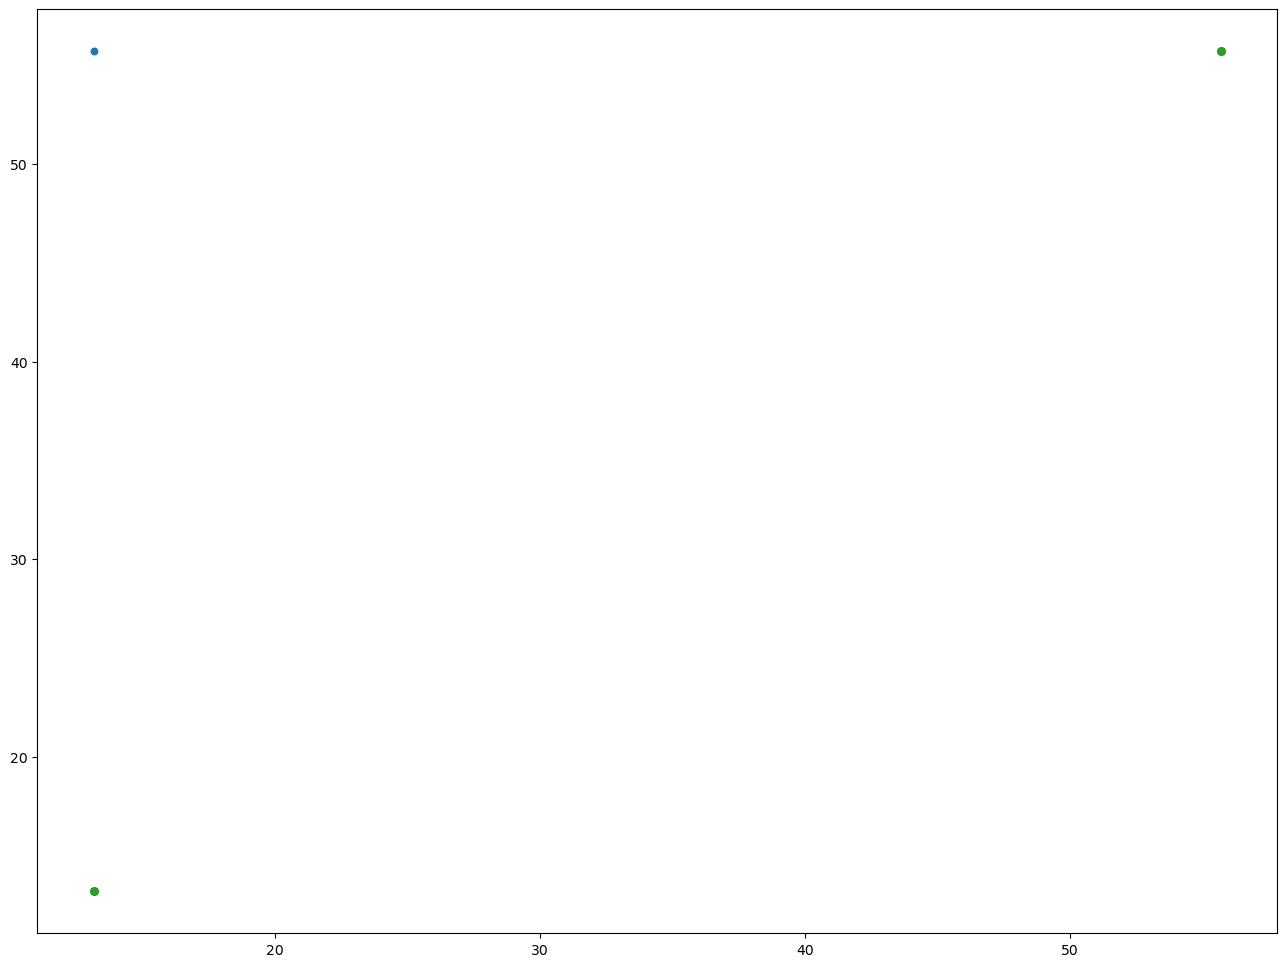

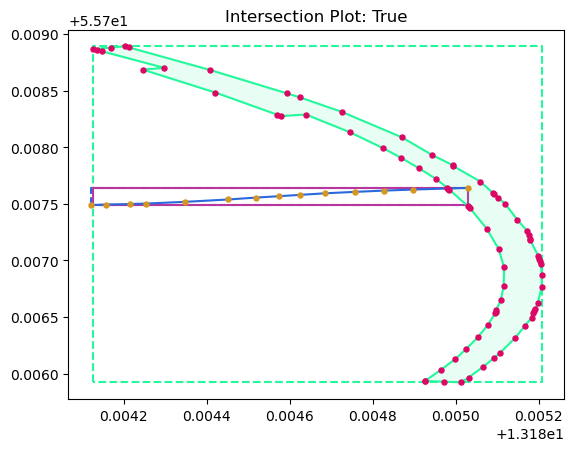

Above FAILED!
Expected shape: LINESTRING (13.18503 55.7076404, 13.1849814 55.7076348)
Returned shape: [[array([13.1849814, 55.7076348])], [[[(13.18503, 55.7076404), (13.1849814, 55.7076348)], [(13.1849814, 55.7076348), (13.1848977, 55.7076256)], [(13.1848977, 55.7076256), (13.184826, 55.7076162)], [(13.184826, 55.7076162), (13.1847561, 55.707605)], [(13.1847561, 55.707605), (13.184685, 55.7075925)], [(13.184685, 55.7075925), (13.1846256, 55.7075787)], [(13.1846256, 55.7075787), (13.1845737, 55.7075667)], [(13.1845737, 55.7075667), (13.1845187, 55.7075547)], [(13.1845187, 55.7075547), (13.1844523, 55.7075379)], [(13.1844523, 55.7075379), (13.1843488, 55.7075172)], [(13.1843488, 55.7075172), (13.1842529, 55.7075016)], [(13.1842529, 55.7075016), (13.184215, 55.7074976)], [(13.184215, 55.7074976), (13.1841578, 55.7074933)], [(13.1841578, 55.7074933), (13.1841215, 55.7074888)]], [[(13.1850288, 55.7074793), (13.1849839, 55.707626)], [(13.1849839, 55.707626), (13.1849814, 55.7076348)], [(13.1

In [5]:
total = 0
passed = 0
def evaluate_dataset(data, plot, total, passed):
    for g1, g2 in data:
        #is_intersecting, intersect_points = binary_intersection(g1, g2)

        _, b1 = fpd.compress(g1)
        _, b2 = fpd.compress(g2)
        exp_boolean = shapely.intersects(g1, g2)
        #is_intersecting = chunk_bbox_is_intersecting((b1, b2), exp_boolean, True)
        is_intersecting = fpd.is_intersecting((b1, b2))[1]

        exp_shape = shapely.intersection(g1, g2)
        intersection = chunk_bbox_intersection((b1, b2), exp_boolean, True)

        if plot and exp_boolean: # Now only plotting intersecting shapes
            if False: # Plot chunks?
                plot_chunks_bounds(b1, True, avoid_show=True)
                plot_chunks_bounds(b2, True, avoid_create_frame=True)
                
            geoms = (g1, g2)
            for g in geoms:
                plot_geometry(g, SHOW_GEOMETRIES)
                plot_geometry_bbox(g, SHOW_BOUNDING_BOXES)
                plot_coordinates(g, SHOW_COORDINATES)
            
            plot_common_bbox(geoms, SHOW_COMMON_BOUNDING_BOX)
            #plot_intersecting_points(intersect_points, legends, SHOW_INTERSECTING_POINTS)

            if SHOW_COORDINATES or SHOW_GEOMETRIES or SHOW_INTERSECTING_POINTS or SHOW_COMMON_BOUNDING_BOX or SHOW_BOUNDING_BOXES:
                plt.title("Intersection Plot: " + ('True' if is_intersecting else 'False'))
                plt.show()

            PLOT_RESULTING_INTERSECTION = False
            if is_intersecting and PLOT_RESULTING_INTERSECTION:
                for g in geoms:
                    plot_geometry(g, SHOW_GEOMETRIES, alpha=0.1)
                plot_geometry(exp_shape)
                plot_coordinates(exp_shape)
                plt.title("Intersecting Shape")
                plt.show()

            if is_intersecting != exp_boolean or intersection != exp_shape:
                print("Above FAILED!")
            else:
                print("Passed!")
                
        print('Expected shape:', exp_shape)
        print('Returned shape:', intersection)
        
        total += 1
        if is_intersecting == exp_boolean:
            passed += 1
        if total % 100 == 0:
            print(f"Passed {passed} of {total}. Total in set: {len(data)}")
    return total, passed

total, passed = evaluate_dataset(manual_data, True, total, passed) # Second param: PLOT?
total, passed = evaluate_dataset(world_data, True, total, passed)
total, passed = evaluate_dataset(lund_data, True, total, passed)

print(f'Done. Passed: {passed} of {total}.')
if passed != total:
    raise(Exception("Failed intersection!"))